In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_bikes = pd.read_csv('../availability.csv')
df_bikes['time_stamp'] = pd.to_datetime(df_bikes['time_stamp']).dt.round('H')
df_bikes = df_bikes.groupby(['id', 'time_stamp']).agg({'bikes': 'mean', 'bike_stands': 'mean'}).reset_index()

In [3]:
df_bikes.head()

,id,time_stamp,bikes,bike_stands
0,1,2024-01-01 00:00:00,23.0,8.0
1,1,2024-01-01 01:00:00,23.0,8.0
2,1,2024-01-01 02:00:00,23.0,8.0
3,1,2024-01-01 03:00:00,23.0,8.0
4,1,2024-01-01 04:00:00,23.0,8.0


In [4]:
len(df_bikes)

164160

In [5]:
df_weather = pd.read_csv('../hourlyWeather.csv')
df_weather['time_stamp'] = pd.to_datetime(df_weather['time_stamp']).dt.round('H')

In [6]:
df_weather.head()

,time_stamp,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,2024-01-01 00:00:00,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,2024-01-01 01:00:00,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,2024-01-01 02:00:00,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,2024-01-01 03:00:00,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,2024-01-01 04:00:00,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [7]:
len(df_weather) * 114

164160

In [8]:
df = pd.merge(df_bikes, df_weather, on='time_stamp', how='inner')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df.head()

,id,time_stamp,bikes,bike_stands,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,1,2024-01-01 00:00:00,23.0,8.0,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,1,2024-01-01 01:00:00,23.0,8.0,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,1,2024-01-01 02:00:00,23.0,8.0,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,1,2024-01-01 03:00:00,23.0,8.0,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,1,2024-01-01 04:00:00,23.0,8.0,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [9]:
X = df[['time_stamp', 'id', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
X['time_stamp'] = (X['time_stamp'].astype(int) / 10**9).astype(int)
y = df[['bikes', 'bike_stands']]

In [10]:
X.head()

,time_stamp,id,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
0,1704067200,1,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
1,1704070800,1,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2,1704074400,1,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
3,1704078000,1,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
4,1704081600,1,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### ARIMA

In [12]:
ts_df = df.drop('bike_stands', axis=1)
ts_df = ts_df[ts_df['id'] == 1]
ts_df = ts_df.drop('id', axis=1)
ts_df['time_stamp'] = pd.to_datetime(ts_df['time_stamp'])
ts_df = ts_df.set_index('time_stamp')
exog_data = ts_df[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
ts_df.head()

,bikes,temp_c,feelslike_c,wind_kph,humidity,precip_mm,gust_kph,wind_degree,pressure_mb,cloud,uv
time_stamp,,,,,,,,,,,
2024-01-01 00:00:00,23.0,5.8,1.1,30.1,84.33,0.078,50.0,257,994.4,64.9,0
2024-01-01 01:00:00,23.0,5.0,0.1,29.9,86.73,0.000,68.8,257,994.8,25.0,0
2024-01-01 02:00:00,23.0,4.8,-0.1,28.5,83.05,0.000,48.2,257,995.5,17.2,0
2024-01-01 03:00:00,23.0,4.5,0.0,24.0,83.87,0.000,42.5,254,996.4,17.3,0
2024-01-01 04:00:00,23.0,4.7,0.5,22.3,82.67,0.000,61.6,240,997.2,17.2,0


In [13]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Number Of Values Used For ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ", dftest[0])
    for key, val in dftest[4].items():
        print("\t", key, " : ", val)

In [14]:
ad_test(ts_df['bikes'])

1. ADF :  -5.70194664427757
2. P-Value :  7.640084280961699e-07
3. Num Of Lags :  24
4. Number Of Values Used For ADF Regression and Critical Values Calculation :  1414
5. Critical Values :  -5.70194664427757
	 1%  :  -3.4349831053858746
	 5%  :  -2.863586191208161
	 10%  :  -2.567859382293453


In [15]:
from pmdarima import auto_arima

In [16]:
stepwise_fit = auto_arima(ts_df['bikes'], exogenous=exog_data, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7276.161, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10343.791, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7343.316, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8950.530, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11726.177, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7277.049, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7273.925, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7280.389, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=7273.891, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=7274.710, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7272.383, Time=0.44 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7275.258, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7273.707, Time=0.60 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=7274.479, Time=0.13 sec
 ARIMA(4,0,2)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1439
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -3624.144
Date:                Sun, 17 Mar 2024   AIC                           7268.287
Time:                        19:45:09   BIC                           7321.004
Sample:                             0   HQIC                          7287.967
                               - 1439                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4238      0.326      4.366      0.000       0.785       2.063
ar.L1          1.1921      0.102     11.736      0.000       0.993       1.391
ar.L2         -0.0045      0.169     -0.027      0.979      -0.336       0.327
ar.L3         -1.0085      0.153     -6.582      0.000      -1.309      -0.708
ar.L4          0.6937      0.083      8.368      0.000       0.531       0.856
ma.L1         -0.0596      0.101     -0.588      0.557      -0.258       0.139
ma.L2         -0.2639      0.094     -2.822      0.005      -0.447      -0.081
ma.L3          0.7364      0.078      9.501      0.000       0.584       0.888
ma.L4          0.2139      0.028      7.679      0.000       0.159       0.269
sigma2         8.9986      0.228     39.532      0.000       8.552       9.445
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5246.54
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
print(ts_df.shape)
train = ts_df.iloc[:-30]
test = ts_df.iloc[-30:]
print(train.shape, test.shape)

exog_train = train[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]
exog_test = test[['temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud', 'uv']]

(1439, 11)
(1409, 11) (30, 11)


In [19]:
model = ARIMA(train['bikes'], order=(4, 0, 4), exog=exog_train)
model = model.fit()
model.summary()

/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  bikes   No. Observations:                 1409
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -3579.772
Date:                Sun, 17 Mar 2024   AIC                           7199.545
Time:                        19:46:02   BIC                           7304.558
Sample:                             0   HQIC                          7238.788
                               - 1409                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          27.8177     73.474      0.379      0.705    -116.189     171.825
temp_c         -1.2520      0.275     -4.546      0.000      -1.792      -0.712
feelslike_c     0.3320      0.178      1.862      0.063      -0.017       0.681
wind_kph        0.1225      0.030      4.103      0.000       0.064       0.181
humidity       -0.0365      0.030     -1.219      0.223      -0.095       0.022
precip_mm      -0.0537      0.176     -0.305      0.760      -0.399       0.291
gust_kph        0.0253      0.011      2.300      0.021       0.004       0.047
wind_degree     0.0004      0.003      0.139      0.889      -0.006       0.006
pressure_mb    -0.0128      0.072     -0.177      0.860      -0.154       0.129
cloud           0.0272      0.007      4.147      0.000       0.014       0.040
uv              0.7116      0.128      5.578      0.000       0.462       0.962
ar.L1           0.9379      0.138      6.818      0.000       0.668       1.207
ar.L2          -0.1455      0.181     -0.804      0.422      -0.500       0.209
ar.L3          -0.4529      0.182     -2.494      0.013      -0.809      -0.097
ar.L4           0.5281      0.132      4.001      0.000       0.269       0.787
ma.L1           0.1840      0.135      1.362      0.173      -0.081       0.449
ma.L2           0.1618      0.141      1.147      0.252      -0.115       0.438
ma.L3           0.5972      0.138      4.321      0.000       0.326       0.868
ma.L4           0.2194      0.030      7.212      0.000       0.160       0.279
sigma2          9.2125      0.236     39.098      0.000       8.751       9.674
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              4447.41
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.forecast(steps=len(test), exog=exog_test, typ='linear')
pred.index = ts_df.index[start:end+1]
print(pred)

time_stamp
2024-02-28 18:00:00    14.058463
2024-02-28 19:00:00    13.289260
2024-02-28 20:00:00    13.560489
2024-02-28 21:00:00    12.898651
2024-02-28 22:00:00    13.432618
2024-02-28 23:00:00    13.441160
2024-02-29 00:00:00    13.852563
2024-02-29 01:00:00    14.161986
2024-02-29 02:00:00    12.984859
2024-02-29 03:00:00    13.230225
2024-02-29 04:00:00    13.313088
2024-02-29 05:00:00    13.613370
2024-02-29 06:00:00    13.659311
2024-02-29 07:00:00    13.989317
2024-02-29 08:00:00    13.441604
2024-02-29 09:00:00    13.688951
2024-02-29 10:00:00    13.602143
2024-02-29 11:00:00    13.921544
2024-02-29 12:00:00    14.353427
2024-02-29 13:00:00    15.119249
2024-02-29 14:00:00    13.929180
2024-02-29 15:00:00    11.996848
2024-02-29 16:00:00    12.604838
2024-02-29 17:00:00    14.051507
2024-02-29 18:00:00    12.400698
2024-02-29 19:00:00    12.383736
2024-02-29 20:00:00    12.486044
2024-02-29 21:00:00    12.478370
2024-02-29 22:00:00    13.561094
2024-02-29 23:00:00    13.289866

/Users/musaddique33/anaconda3/envs/comp30830/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='time_stamp'>

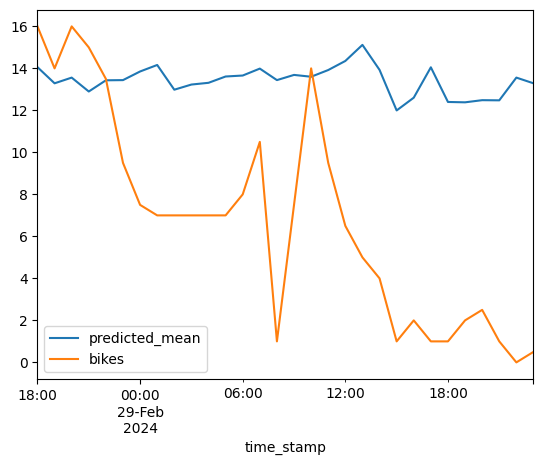

In [21]:
pred.plot(legend=True)
test['bikes'].plot(legend=True)

#

In [22]:
def round_nearest(value):
    integer_part = int(value)
    fractional_part = value - integer_part
    if fractional_part >= 0.5:
        return integer_part + 1
    else:
        return integer_part

In [23]:
def model_performance_trees(regrssor, output, algorithm):
    regrssor.fit(X_train, y_train[output])
    y_pred = regrssor.predict(X_test)
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], y_pred)
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], y_pred)
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], y_pred)
    print("R-squared : ", r2)

    plt.scatter(y_test[output], y_pred, marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()

In [24]:
def BayesSearch(model, param_space, output):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train, y_train[output])
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### XGBoost

In [25]:
from xgboost import XGBRegressor

In [26]:
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (3, 10),
    'n_estimators': (100, 500),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 1.0, 'uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform')
}

# regressor_xgb = XGBRegressor()
# BayesSearch(regressor_xgb, param_space, 'bikes')

Best parameters found: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.15964894124790666, 'learning_rate': 0.09587460498414789, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.8997253368774076})

XGBoost 	 bikes
MAE :  4.657176467736531
MSE :  35.62691409860644
R-squared :  0.630717249534184


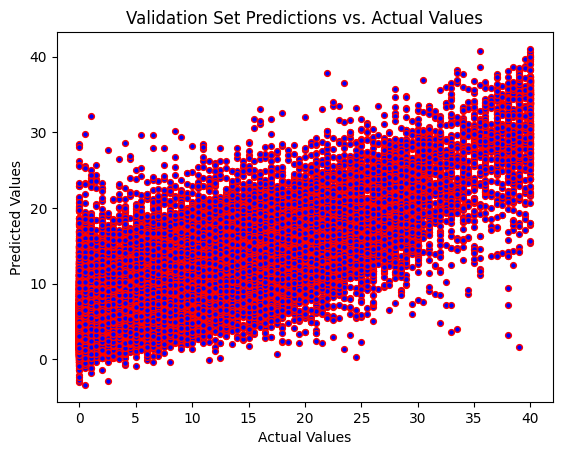

In [27]:
model_xgb = XGBRegressor(colsample_bytree=1.0, 
                        gamma=0.15964894124790666, 
                        learning_rate=0.09587460498414789, 
                        max_depth=6, 
                        min_child_weight=10, 
                        n_estimators=500, 
                        subsample=0.8997253368774076)

model_performance_trees(model_xgb, 'bikes', 'XGBoost')

XGBoost 	 bike_stands
MAE :  4.676336788198309
MSE :  36.041279023147446
R-squared :  0.7129470063674996


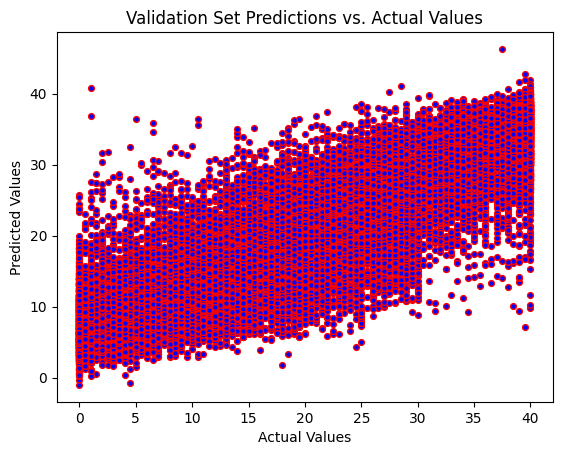

In [28]:
model_xgb2 = XGBRegressor(colsample_bytree=1.0, 
                        gamma=0.15964894124790666, 
                        learning_rate=0.09587460498414789, 
                        max_depth=6, 
                        min_child_weight=10, 
                        n_estimators=500, 
                        subsample=0.8997253368774076)

model_performance_trees(model_xgb2, 'bike_stands', 'XGBoost')

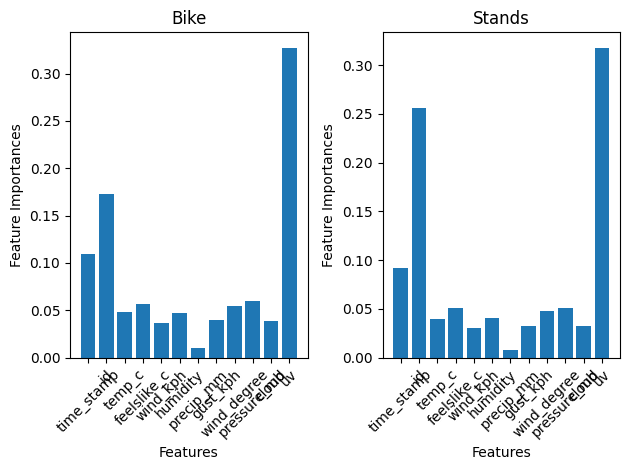

In [29]:
feature_importances_rf2 = model_xgb2.feature_importances_
feature_importances_rf1 = model_xgb.feature_importances_
features = X_train.columns

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.bar(features, feature_importances_rf1)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Bike')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(features, feature_importances_rf2)
plt.xlabel('Features')
plt.ylabel('Feature Importances')
plt.title('Stands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
bikes = np.vectorize(round_nearest)(model_xgb.predict(X_test))
stands = np.vectorize(round_nearest)(model_xgb2.predict(X_test))
for i in range(10):
    print(f'Predicted: Bikes={bikes[i]}, Bike Stands={stands[i]} | Actual: Bikes={y_test['bikes'].values[i]}, Bike Stands={y_test['bike_stands'].values[i]}')

Predicted: Bikes=10, Bike Stands=17 | Actual: Bikes=3.5, Bike Stands=26.5
Predicted: Bikes=16, Bike Stands=21 | Actual: Bikes=28.0, Bike Stands=12.0
Predicted: Bikes=10, Bike Stands=31 | Actual: Bikes=13.0, Bike Stands=27.0
Predicted: Bikes=7, Bike Stands=32 | Actual: Bikes=0.5, Bike Stands=39.5
Predicted: Bikes=15, Bike Stands=6 | Actual: Bikes=18.5, Bike Stands=1.5
Predicted: Bikes=13, Bike Stands=19 | Actual: Bikes=14.0, Bike Stands=16.0
Predicted: Bikes=4, Bike Stands=27 | Actual: Bikes=6.5, Bike Stands=25.5
Predicted: Bikes=6, Bike Stands=13 | Actual: Bikes=11.5, Bike Stands=8.5
Predicted: Bikes=19, Bike Stands=19 | Actual: Bikes=12.5, Bike Stands=27.5
Predicted: Bikes=14, Bike Stands=16 | Actual: Bikes=13.5, Bike Stands=16.5


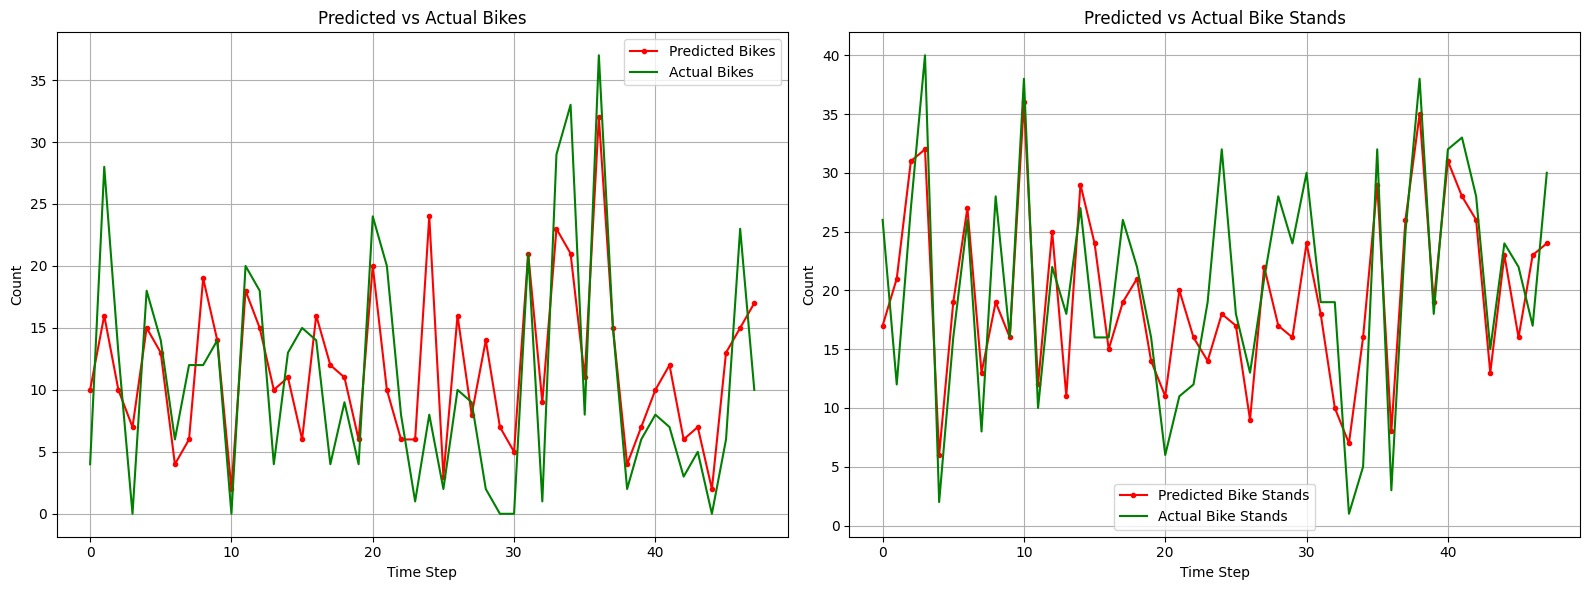

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#

In [32]:
def model_performance_non_bikes(regrssor, output, algorithm, X_train_processed, y_train_processed, preprocessor, scalar):
    regrssor.fit(X_train_processed, y_train_processed)
    y_pred = regrssor.predict(preprocessor.transform(X_test))
    
    print(algorithm, "\t", output)
    mae = mean_absolute_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MAE : ", mae)
    mse = mean_squared_error(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("MSE : ", mse)
    r2 = r2_score(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)))
    print("R-squared : ", r2)

    plt.scatter(y_test[output], scalar.inverse_transform(y_pred.reshape(-1, 1)), marker='.', color='blue' ,edgecolors='red', s=70)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set Predictions vs. Actual Values')
    plt.show()


In [33]:
def BayesSearch_non_tree(model, param_space, y_train_processed, X_train_processed):
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=param_space,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    bayes_search.fit(X_train_processed, y_train_processed)
    best_params = bayes_search.best_params_
    print("Best parameters found:", best_params)

### KNN

In [34]:
from sklearn.neighbors import KNeighborsRegressor

In [35]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud']),
        ('cat', OneHotEncoder(), ['uv', 'id'])
    ])
X_train_processed = preprocessor_knn.fit_transform(X_train)

In [36]:
scalar1 = StandardScaler()
y_train_processed1 = scalar1.fit_transform(y_train['bikes'].values.reshape(-1, 1))
scalar2 = StandardScaler()
y_train_processed2 = scalar2.fit_transform(y_train['bike_stands'].values.reshape(-1, 1))

In [37]:
param_space = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'p': [1, 2] 
}

# regressor_knn = KNeighborsRegressor()
# BayesSearch_non_tree(regressor_knn, param_space, y_train_processed1, X_train_processed)

Best parameters found: OrderedDict({'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

KNN 	 bikes
MAE :  4.289499834431785
MSE :  43.9172256325313
R-squared :  0.5447858933411422


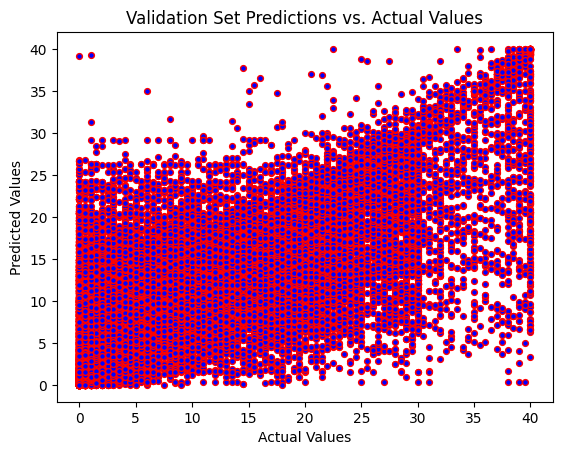

In [38]:
model_knn = KNeighborsRegressor(algorithm='auto', n_neighbors=3, p=1, weights='distance')
model_performance_non_bikes(model_knn, 'bikes', 'KNN', X_train_processed, y_train_processed1, preprocessor_knn, scalar1)

KNN 	 bike_stands
MAE :  4.759991420741839
MSE :  53.89279286704314
R-squared :  0.5707675213810985


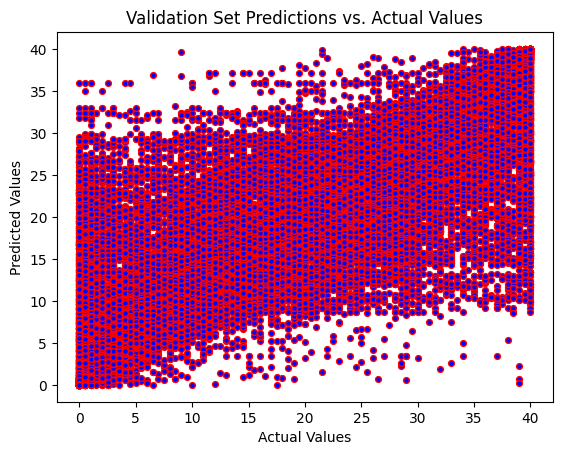

In [39]:
model_knn2 = KNeighborsRegressor(algorithm='auto', n_neighbors=3, p=1, weights='distance')
model_performance_non_bikes(model_knn2, 'bike_stands', 'KNN', X_train_processed, y_train_processed2, preprocessor_knn, scalar2)

In [40]:
bikes = np.vectorize(round_nearest)(scalar1.inverse_transform(model_knn.predict(preprocessor_knn.transform(X_test))))
stands = np.vectorize(round_nearest)(scalar2.inverse_transform(model_knn2.predict(preprocessor_knn.transform(X_test))))
for i in range(10):
    print(f'Predicted: Bikes={np.round(bikes)[i]}, Bike Stands={np.round(stands)[i]} | Actual: Bikes={np.round(y_test['bikes'].values)[i]}, Bike Stands={np.round(y_test['bike_stands'].values)[i]}')

Predicted: Bikes=[8], Bike Stands=[23] | Actual: Bikes=4.0, Bike Stands=26.0
Predicted: Bikes=[19], Bike Stands=[21] | Actual: Bikes=28.0, Bike Stands=12.0
Predicted: Bikes=[12], Bike Stands=[28] | Actual: Bikes=13.0, Bike Stands=27.0
Predicted: Bikes=[11], Bike Stands=[23] | Actual: Bikes=0.0, Bike Stands=40.0
Predicted: Bikes=[13], Bike Stands=[16] | Actual: Bikes=18.0, Bike Stands=2.0
Predicted: Bikes=[10], Bike Stands=[15] | Actual: Bikes=14.0, Bike Stands=16.0
Predicted: Bikes=[8], Bike Stands=[32] | Actual: Bikes=6.0, Bike Stands=26.0
Predicted: Bikes=[12], Bike Stands=[8] | Actual: Bikes=12.0, Bike Stands=8.0
Predicted: Bikes=[6], Bike Stands=[26] | Actual: Bikes=12.0, Bike Stands=28.0
Predicted: Bikes=[15], Bike Stands=[11] | Actual: Bikes=14.0, Bike Stands=16.0


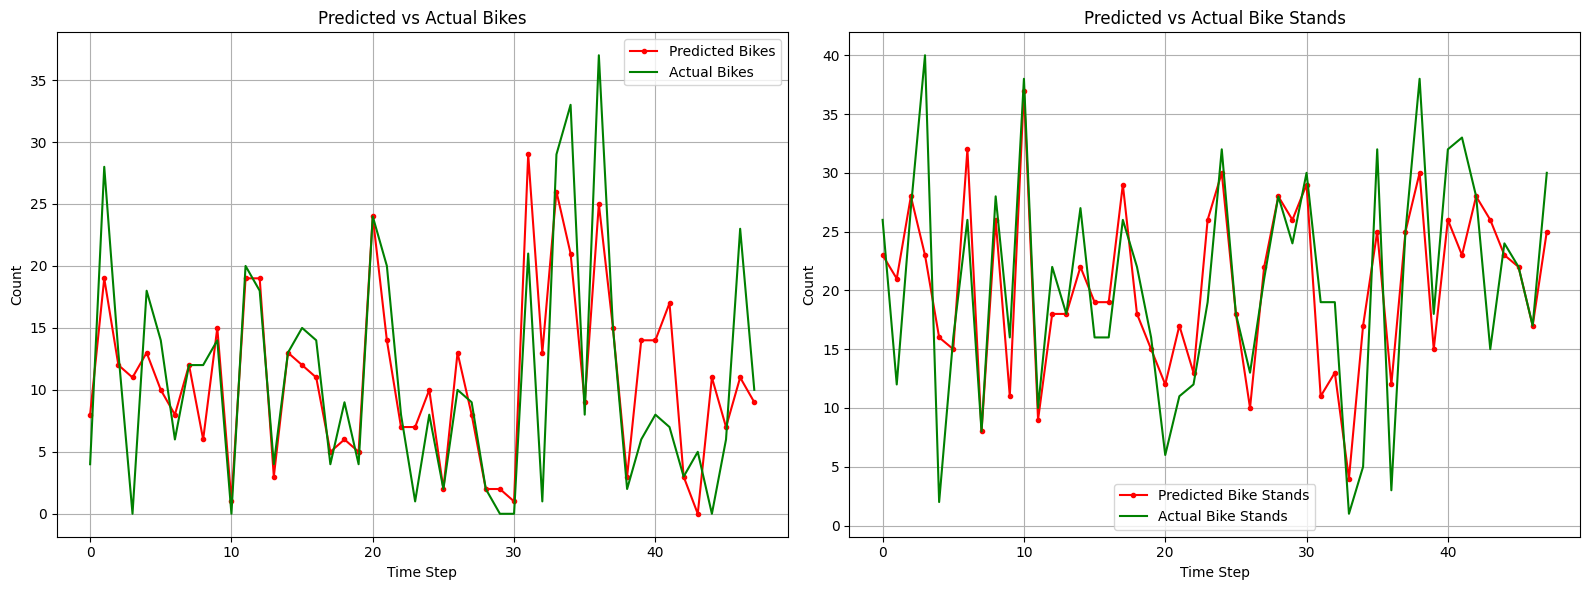

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(np.round(bikes)[:48], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(np.round(y_test['bikes'].values)[:48], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.round(stands)[:48], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(np.round(y_test['bike_stands'].values)[:48], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

### ANN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [43]:
preprocessor_ann = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['time_stamp', 'temp_c', 'feelslike_c', 'wind_kph', 'humidity', 'precip_mm', 'gust_kph', 'wind_degree', 'pressure_mb', 'cloud']),
        ('cat', OneHotEncoder(), ['uv', 'id'])
    ])
X_train_processed = preprocessor_ann.fit_transform(X_train)
scalar = StandardScaler()
y_train_processed = scalar.fit_transform(y_train.values)

In [44]:
input_shape = X_train_processed.shape[1:]

In [45]:
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2)
])
ann_model.compile(optimizer='adam', loss='mse')

In [46]:
ann_model.fit(X_train_processed.toarray(), y_train_processed, epochs=10, batch_size=8, validation_data=(preprocessor_ann.transform(X_test).toarray(), scalar.transform(y_test.values)))

Epoch 1/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 667us/step - loss: 0.5842 - val_loss: 0.4297
Epoch 2/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 687us/step - loss: 0.3900 - val_loss: 0.3648
Epoch 3/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 12s 709us/step - loss: 0.3201 - val_loss: 0.3087
Epoch 4/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 667us/step - loss: 0.2741 - val_loss: 0.2789
Epoch 5/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 12s 709us/step - loss: 0.2420 - val_loss: 0.2601
Epoch 6/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 12s 739us/step - loss: 0.2204 - val_loss: 0.2468
Epoch 7/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 10s 637us/step - loss: 0.2026 - val_loss: 0.2331
Epoch 8/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 10s 629us/step - loss: 0.1889 - val_loss: 0.2150
Epoch 9/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 11s 651us/step - loss: 0.1768 - val_loss: 0.2204
Epoch 10/10
16405/16405 ━━━━━━━━━━━━━━━━━━━━ 13s 781us/step - loss: 0.1686 - val_loss: 0.2112


In [47]:
X_test_processed = preprocessor_ann.transform(X_test)
y_pred = ann_model.predict(X_test_processed.toarray())

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


In [48]:
predictions_inv = scalar.inverse_transform(y_pred)
y_test_inv = y_test.values

predictions_inv= np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

Predicted: Bikes=8, Bike Stands=22 | Actual: Bikes=4, Bike Stands=27
Predicted: Bikes=30, Bike Stands=9 | Actual: Bikes=28, Bike Stands=12
Predicted: Bikes=12, Bike Stands=28 | Actual: Bikes=13, Bike Stands=27
Predicted: Bikes=6, Bike Stands=34 | Actual: Bikes=1, Bike Stands=40
Predicted: Bikes=19, Bike Stands=1 | Actual: Bikes=19, Bike Stands=2
Predicted: Bikes=11, Bike Stands=19 | Actual: Bikes=14, Bike Stands=16
Predicted: Bikes=7, Bike Stands=25 | Actual: Bikes=7, Bike Stands=26
Predicted: Bikes=18, Bike Stands=1 | Actual: Bikes=12, Bike Stands=9
Predicted: Bikes=14, Bike Stands=26 | Actual: Bikes=13, Bike Stands=28
Predicted: Bikes=24, Bike Stands=6 | Actual: Bikes=14, Bike Stands=17


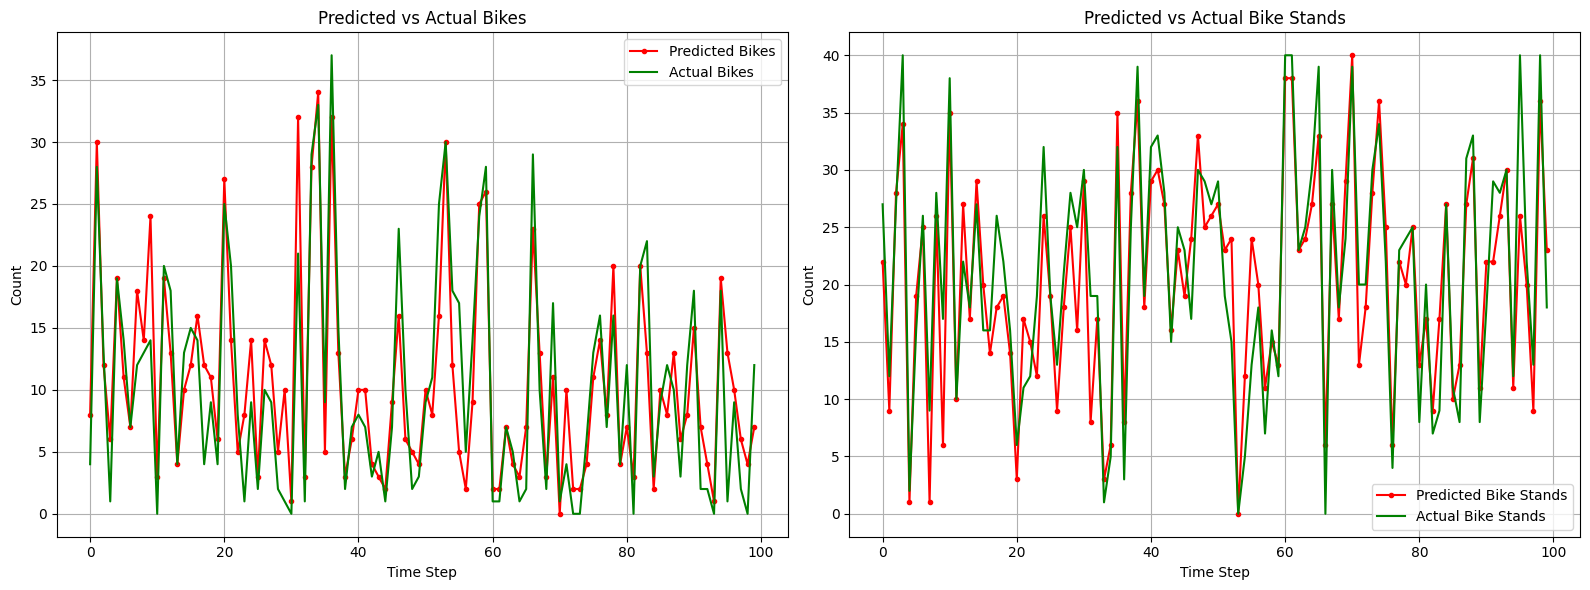

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:100, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:100, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:100, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:100, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [50]:
predict_test = scalar.inverse_transform(y_pred)

mae = mean_absolute_error(y_test, predict_test)
print("MAE : ", mae)
mse = mean_squared_error(y_test, predict_test)
print("MSE : ", mse)
r2 = r2_score(y_test, predict_test)
print("R-squared : ", r2)

MAE :  3.529550496846122
MSE :  22.944995525735393
R-squared :  0.7899174507569404


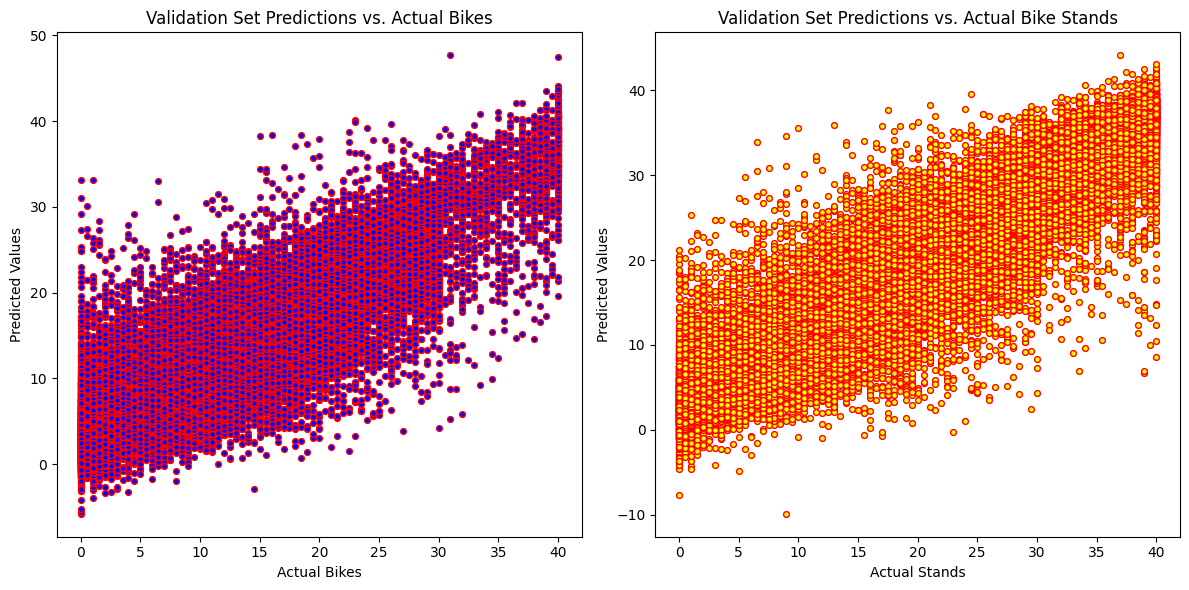

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test['bikes'], predict_test[:, 0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test['bike_stands'], predict_test[:, 1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

### RNN

In [93]:
from tensorflow.keras.layers import LSTM, Dropout

In [130]:
df_rnn = df[df['id'] == 42]
# df_rnn = df.copy()
df_rnn['time_stamp'] = pd.to_datetime(df_rnn['time_stamp'])
df_rnn.set_index('time_stamp', inplace=True)
df_rnn = df_rnn.drop('id', axis=1)
X = df_rnn.drop(columns=['bikes', 'bike_stands'])
y = df_rnn[['bikes', 'bike_stands']]

In [131]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [132]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(data.shape[0] - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [133]:
sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

In [134]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [135]:
X_train_rnn.shape

(1132, 24, 10)

In [136]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.1),
    LSTM(units=128, return_sequences=False),
    Dense(units=2)
])

model.compile(optimizer='adam', loss='mse')

In [137]:
model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=16)

Epoch 1/10


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.8735
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.5079
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.3281
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2562
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1799
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2325
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0975
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1468
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1002
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0837


In [138]:
loss = model.evaluate(X_test_rnn, y_test_rnn)
print(f'Test Loss: {loss}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1199 
Test Loss: 0.10949726402759552


In [139]:
predictions = model.predict(X_test_rnn)

predictions_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test_rnn)

predictions_inv = np.vectorize(round_nearest)(predictions_inv)
y_test_inv = np.vectorize(round_nearest)(y_test_inv)

for i in range(10):
    print(f'Predicted: Bikes={predictions_inv[i][0]}, Bike Stands={predictions_inv[i][1]} | Actual: Bikes={y_test_inv[i][0]}, Bike Stands={y_test_inv[i][1]}')

8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: Bikes=23, Bike Stands=7 | Actual: Bikes=28, Bike Stands=3
Predicted: Bikes=27, Bike Stands=3 | Actual: Bikes=30, Bike Stands=0
Predicted: Bikes=22, Bike Stands=7 | Actual: Bikes=24, Bike Stands=6
Predicted: Bikes=24, Bike Stands=6 | Actual: Bikes=23, Bike Stands=7
Predicted: Bikes=9, Bike Stands=21 | Actual: Bikes=2, Bike Stands=28
Predicted: Bikes=18, Bike Stands=11 | Actual: Bikes=21, Bike Stands=10
Predicted: Bikes=25, Bike Stands=5 | Actual: Bikes=30, Bike Stands=0
Predicted: Bikes=18, Bike Stands=12 | Actual: Bikes=20, Bike Stands=10
Predicted: Bikes=24, Bike Stands=6 | Actual: Bikes=23, Bike Stands=7
Predicted: Bikes=15, Bike Stands=15 | Actual: Bikes=16, Bike Stands=14


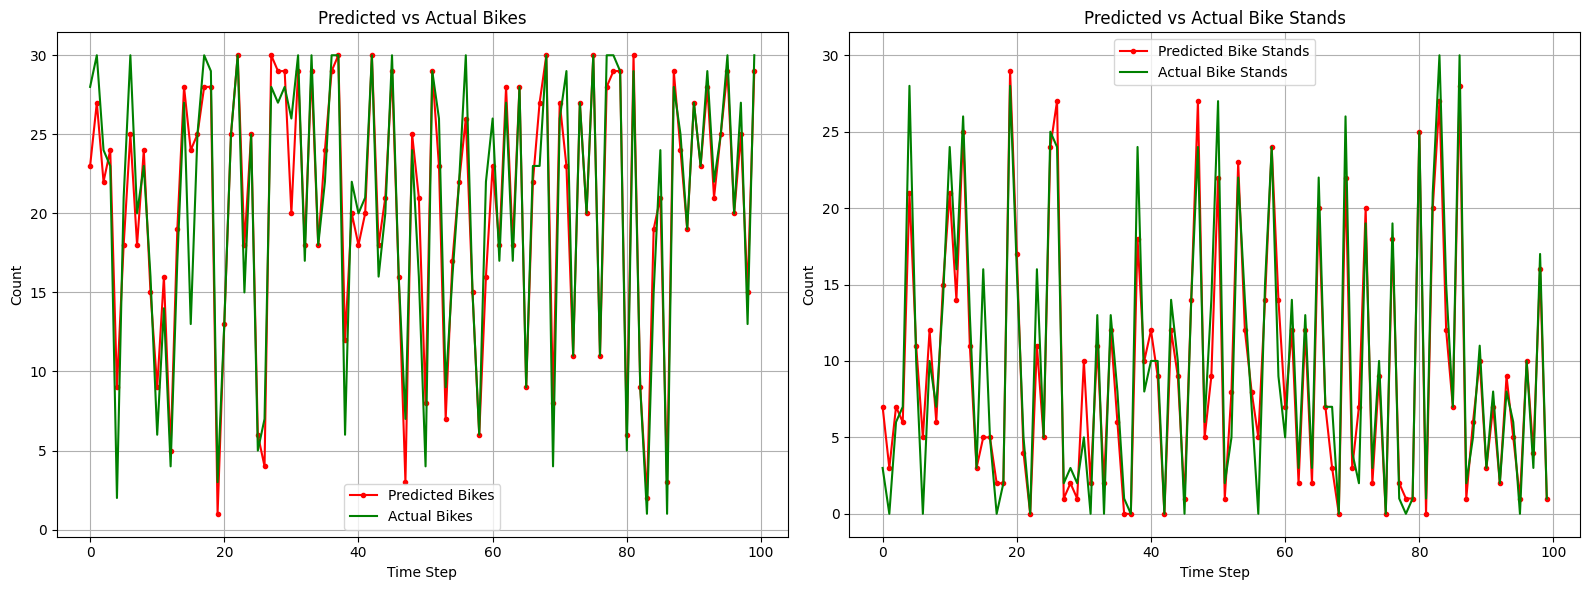

In [142]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(predictions_inv[:100, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_test_inv[:100, 0], label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(predictions_inv[:100, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_test_inv[:100, 1], label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [143]:
mae = mean_absolute_error(predictions_inv[:,0], y_test_inv[:,0])
print("MAE : ", mae)
mse = mean_squared_error(predictions_inv[:,0], y_test_inv[:,0])
print("MSE : ", mse)
r2 = r2_score(predictions_inv[:,0], y_test_inv[:,0])
print("R-squared : ", r2)

MAE :  1.784452296819788
MSE :  6.286219081272085
R-squared :  0.8812831009097297


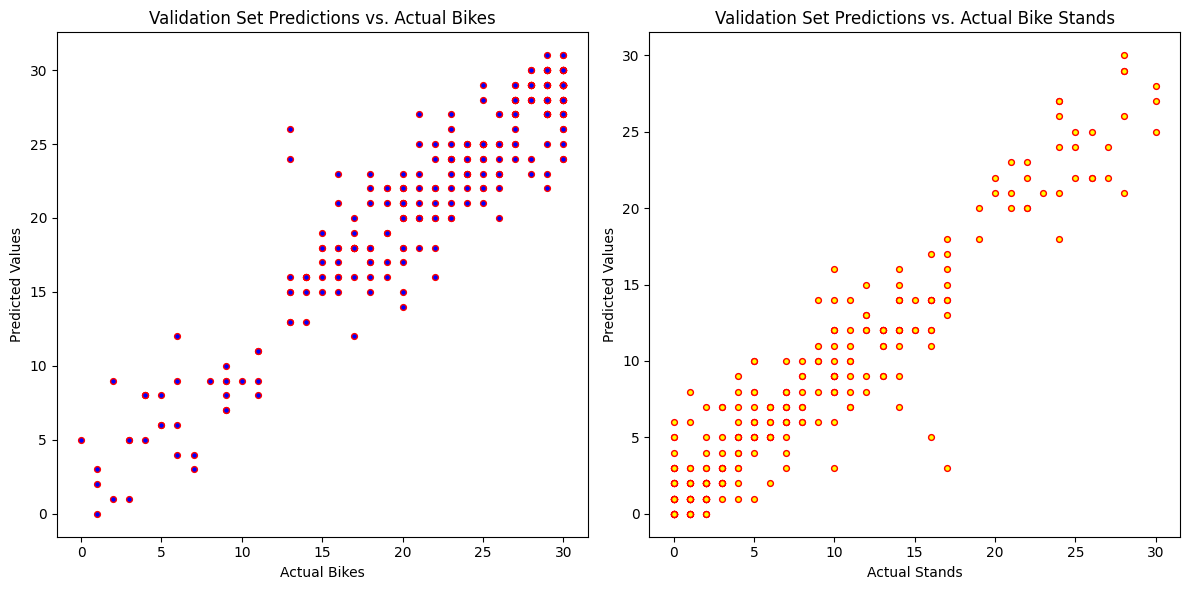

In [144]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_test_inv[:,0], predictions_inv[:,0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_test_inv[:,1], predictions_inv[:,1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

#

#

In [88]:
from datetime import datetime
import requests
import json

link = ' http://api.weatherapi.com/v1/current.json'
api = '1afd61b9571f4d8a8f7133239242702'
contract = 'Dublin'

response = requests.get(link, 
                        params={"key": api, 
                                "q": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)
data.columns

Index(['location.name', 'location.region', 'location.country', 'location.lat',
       'location.lon', 'location.tz_id', 'location.localtime_epoch',
       'location.localtime', 'current.last_updated_epoch',
       'current.last_updated', 'current.temp_c', 'current.temp_f',
       'current.is_day', 'current.condition.text', 'current.condition.icon',
       'current.condition.code', 'current.wind_mph', 'current.wind_kph',
       'current.wind_degree', 'current.wind_dir', 'current.pressure_mb',
       'current.pressure_in', 'current.precip_mm', 'current.precip_in',
       'current.humidity', 'current.cloud', 'current.feelslike_c',
       'current.feelslike_f', 'current.vis_km', 'current.vis_miles',
       'current.uv', 'current.gust_mph', 'current.gust_kph'],
      dtype='object')

In [89]:
sample = pd.DataFrame()
sample['time_stamp'] = pd.to_datetime(data['location.localtime']).dt.round('H')
sample['temp_c'] = data['current.temp_c']
sample['feelslike_c'] = data['current.feelslike_c']
sample['wind_kph'] = data['current.wind_kph']
sample['humidity'] = data['current.humidity']
sample['precip_mm'] = data['current.precip_mm']
sample['gust_kph'] = data['current.gust_kph']
sample['wind_degree'] = data['current.wind_degree']
sample['pressure_mb'] = data['current.pressure_mb']
sample['cloud'] = data['current.cloud']
sample['uv'] = data['current.uv']

In [68]:
from datetime import datetime
import requests
import json

link = 'https://api.jcdecaux.com/vls/v1/stations'
api = '681b757e032447abea03a11443b614d0ba3cf5ef'
contract = 'Dublin'

response = requests.get(link, 
                        params={"apiKey": api, 
                                "contract": contract})
response.raise_for_status()
now = datetime.now()
data = response.text
data = json.loads(data)
data = pd.json_normalize(data)

In [69]:
data.columns

Index(['number', 'contract_name', 'name', 'address', 'banking', 'bonus',
       'bike_stands', 'available_bike_stands', 'available_bikes', 'status',
       'last_update', 'position.lat', 'position.lng'],
      dtype='object')

In [70]:
sample2 = pd.DataFrame()
sample2['id'] = data['number']
sample2['time_stamp'] = pd.to_datetime(data['last_update'], unit='ms').dt.round('H')

In [71]:
result = pd.merge(sample, sample2, on='time_stamp', how='inner')
result['time_stamp'] = (result['time_stamp'].astype(int) / 10**9).astype(int)

In [72]:
X_sample = preprocessor_ann.transform(result)

In [73]:
pred = ann_model.predict(X_sample.toarray())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


In [74]:
pred_inv = scalar.inverse_transform(pred)
pred_inv = np.vectorize(round_nearest)(pred_inv)
y_true = data[['available_bike_stands', 'available_bikes']]
for i in range(10):
    print(f'Predicted: Bikes={pred_inv[i][0]}, Bike Stands={pred_inv[i][1]} | Actual: Bikes={y_true['available_bikes'].values[i]}, Bike Stands={y_true['available_bike_stands'].values[i]}')

Predicted: Bikes=17, Bike Stands=13 | Actual: Bikes=27, Bike Stands=3
Predicted: Bikes=12, Bike Stands=9 | Actual: Bikes=0, Bike Stands=20
Predicted: Bikes=12, Bike Stands=21 | Actual: Bikes=26, Bike Stands=7
Predicted: Bikes=16, Bike Stands=18 | Actual: Bikes=4, Bike Stands=31
Predicted: Bikes=18, Bike Stands=12 | Actual: Bikes=1, Bike Stands=29
Predicted: Bikes=19, Bike Stands=21 | Actual: Bikes=5, Bike Stands=35
Predicted: Bikes=8, Bike Stands=11 | Actual: Bikes=0, Bike Stands=0
Predicted: Bikes=16, Bike Stands=13 | Actual: Bikes=19, Bike Stands=11
Predicted: Bikes=18, Bike Stands=12 | Actual: Bikes=25, Bike Stands=5
Predicted: Bikes=15, Bike Stands=19 | Actual: Bikes=26, Bike Stands=6


In [75]:
pred_inv.shape

(114, 2)

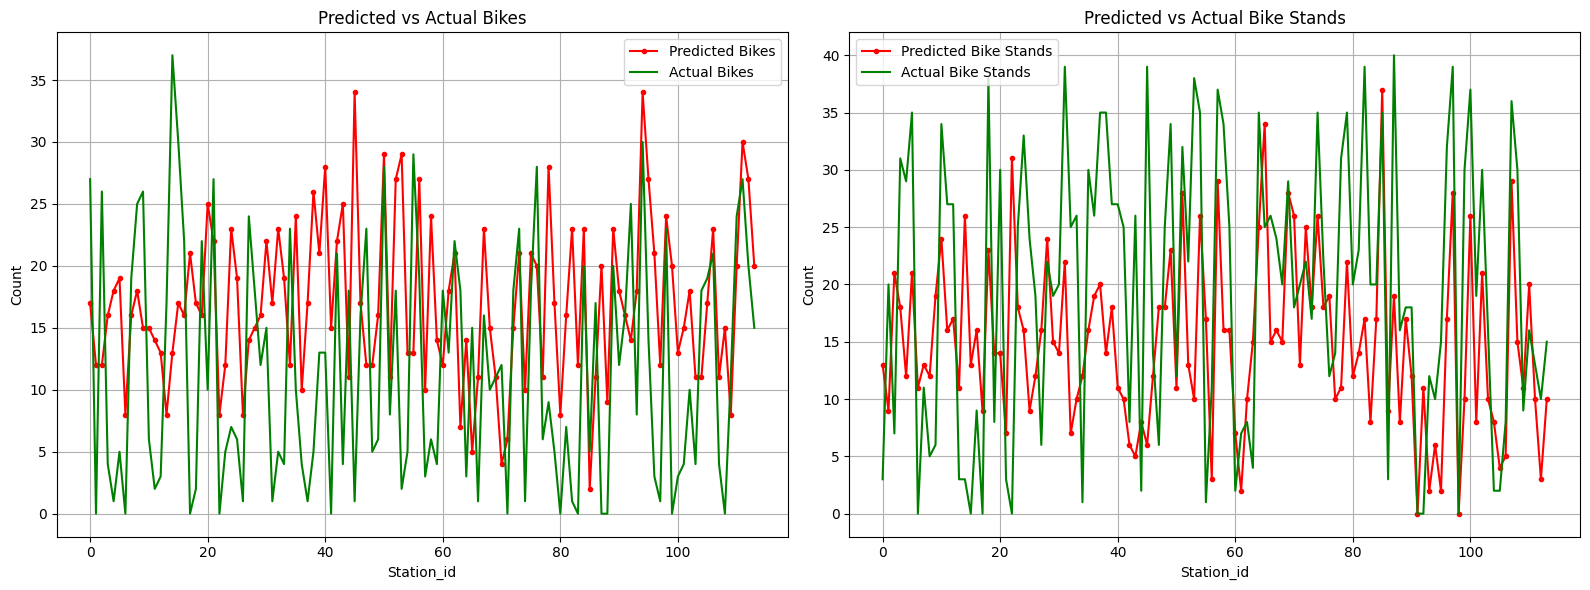

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(pred_inv[:, 0], label='Predicted Bikes', color='red', marker='.')
axs[0].plot(y_true['available_bikes'].values, label='Actual Bikes', color='green')
axs[0].set_title('Predicted vs Actual Bikes')
axs[0].set_xlabel('Station_id')
axs[0].set_ylabel('Count')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(pred_inv[:, 1], label='Predicted Bike Stands', color='red', marker='.')
axs[1].plot(y_true['available_bike_stands'].values, label='Actual Bike Stands', color='green')
axs[1].set_title('Predicted vs Actual Bike Stands')
axs[1].set_xlabel('Station_id')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

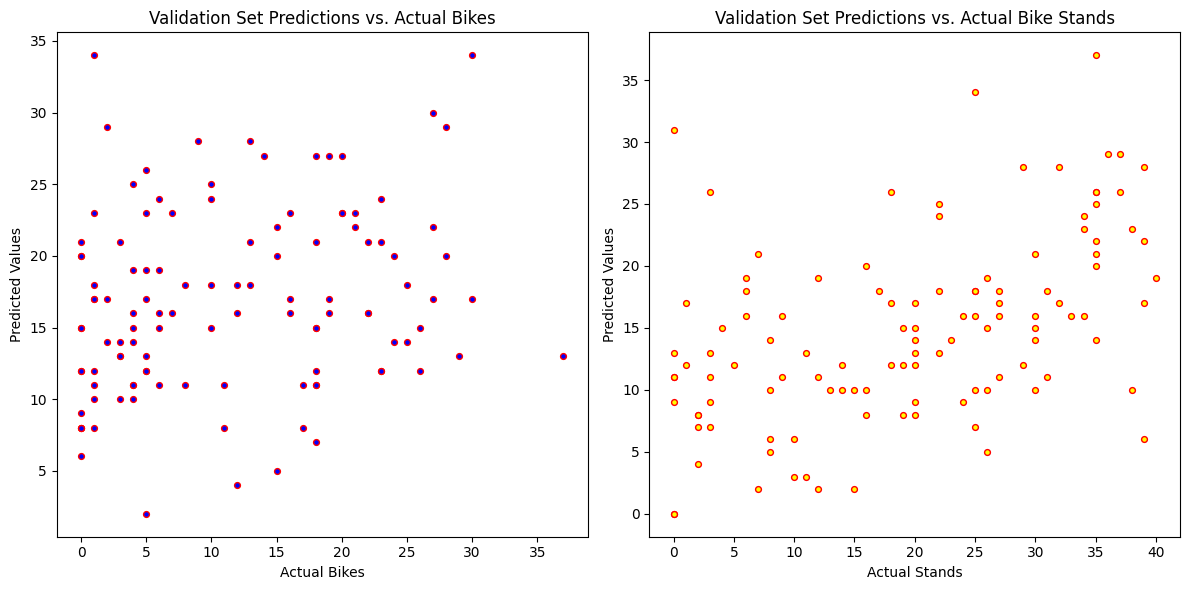

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_true['available_bikes'].values, pred_inv[:, 0], marker='.', color='blue' ,edgecolors='red', s=70)
axs[0].set_xlabel('Actual Bikes')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Validation Set Predictions vs. Actual Bikes')

axs[1].scatter(y_true['available_bike_stands'].values, pred_inv[:, 1], marker='.', color='yellow' ,edgecolors='red', s=70)
axs[1].set_xlabel('Actual Stands')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Validation Set Predictions vs. Actual Bike Stands')

plt.tight_layout()
plt.show()

In [78]:
mae = mean_absolute_error(y_true.values, pred_inv)
print("MAE : ", mae)
mse = mean_squared_error(y_true.values, pred_inv)
print("MSE : ", mse)
r2 = r2_score(y_true.values, pred_inv)
print("R-squared : ", r2)

MAE :  11.421052631578947
MSE :  178.9035087719298
R-squared :  -0.6084038874671784


In [107]:
import numpy as np

# New data point
new_df = sample.copy()

# Convert new data point to DataFrame
# new_df = pd.DataFrame([new_data_point])

# Preprocess the new data point
new_df['time_stamp'] = pd.to_datetime(new_df['time_stamp'])
new_df.set_index('time_stamp', inplace=True)
new_df_scaled = scaler_X.transform(new_df)

# Check the shape of the scaled new data
print("Shape of scaled new data:", new_df_scaled.shape)

# Reshape the new data point for model input
new_data_reshaped = np.reshape(new_df_scaled, (1, new_df_scaled.shape[0], new_df_scaled.shape[1]))

# Predict using the trained model
predicted_scaled = model.predict(new_data_reshaped)

# Inverse scale the predicted values
predicted = scaler_y.inverse_transform(predicted_scaled)

# Display the predicted values
print("Predicted bikes:", predicted[0][0])
print("Predicted bike stands:", predicted[0][1])


Shape of scaled new data: (1, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted bikes: 20.373041
Predicted bike stands: 9.528554


#